# Setup

In [1]:
# import modules

import toolbox_morph
import numpy as np 
import matplotlib.pyplot as plt
from astropy.table import Table
import glob
import dynesty
from dynesty import plotting as dyplot
from dynesty import utils as dyfunc


In [2]:
# define paths

path_main_directory = '/Users/sandrotacchella/ASTRO/SRMP/morph_project/'
path_SFH_table = path_main_directory + 'SFH/Behroozi+19/'


# Set up model

In [3]:
# set up radial bins of the models (don't use too many otherwise everything will be slow...)

radius_kpc = np.logspace(-1.0, 1.3, num=20)
print radius_kpc


[ 0.1         0.13214558  0.17462454  0.2307586   0.30493728  0.40296113
  0.53249531  0.703669    0.92986747  1.22877873  1.62377674  2.14574914
  2.83551258  3.74700446  4.95150067  6.54318913  8.64653503 11.42601361
 15.09897161 19.95262315]


In [4]:
# create list of SFH tables

# list_SFH_tables = glob.glob(path_SFH_table + '*a1.002310.dat')

# just use mass range of logM = 9-12 at z=0
list_SFH_tables = np.append(np.append(glob.glob(path_SFH_table + '*sm9*a1.002310.dat'), glob.glob(path_SFH_table + '*sm10*a1.002310.dat')), glob.glob(path_SFH_table + '*sm11*a1.002310.dat'))

print(list_SFH_tables)
print(len(list_SFH_tables))


['/Users/sandrotacchella/ASTRO/SRMP/morph_project/SFH/Behroozi+19/sfh_sm9.10_a1.002310.dat'
 '/Users/sandrotacchella/ASTRO/SRMP/morph_project/SFH/Behroozi+19/sfh_sm9.30_a1.002310.dat'
 '/Users/sandrotacchella/ASTRO/SRMP/morph_project/SFH/Behroozi+19/sfh_sm9.50_a1.002310.dat'
 '/Users/sandrotacchella/ASTRO/SRMP/morph_project/SFH/Behroozi+19/sfh_sm9.70_a1.002310.dat'
 '/Users/sandrotacchella/ASTRO/SRMP/morph_project/SFH/Behroozi+19/sfh_sm9.90_a1.002310.dat'
 '/Users/sandrotacchella/ASTRO/SRMP/morph_project/SFH/Behroozi+19/sfh_sm10.10_a1.002310.dat'
 '/Users/sandrotacchella/ASTRO/SRMP/morph_project/SFH/Behroozi+19/sfh_sm10.30_a1.002310.dat'
 '/Users/sandrotacchella/ASTRO/SRMP/morph_project/SFH/Behroozi+19/sfh_sm10.50_a1.002310.dat'
 '/Users/sandrotacchella/ASTRO/SRMP/morph_project/SFH/Behroozi+19/sfh_sm10.70_a1.002310.dat'
 '/Users/sandrotacchella/ASTRO/SRMP/morph_project/SFH/Behroozi+19/sfh_sm10.90_a1.002310.dat'
 '/Users/sandrotacchella/ASTRO/SRMP/morph_project/SFH/Behroozi+19/sfh_sm11.

# Observations

## Size-mass relation for star-forming and quiescent galaxies 

In [5]:
# define size-mass relation from observations; these are the observations we want to fit

# Moein+13 for z=0

def Mosleh2013_SF(mass):
    alpha, beta, gamma, M0 = 0.109, 0.263, 10**-0.743, 10**10.204
    return(gamma*mass**alpha*(1+mass/M0)**(beta-alpha))

def Mosleh2013_Q(mass):
    alpha, beta, gamma, M0 = 0.014, 0.912, 10**-0.058, 10**10.555
    return(gamma*mass**alpha*(1+mass/M0)**(beta-alpha))



In [52]:
# Mowla+19 for z>0

Mowla_table = np.array([0.25, 0.74, 0.27, 0.83, 0.29, 0.59, 0.47])
Mowla_table = np.vstack([Mowla_table, np.array([0.75, 0.65, 0.17, 0.74, 0.21, 0.44, 0.57])])
Mowla_table = np.vstack([Mowla_table, np.array([1.25, 0.60, 0.13, 0.67, 0.19, 0.26, 0.65])])
Mowla_table = np.vstack([Mowla_table, np.array([1.75, 0.53, 0.09, 0.61, 0.18, 0.17, 0.63])])
Mowla_table = np.vstack([Mowla_table, np.array([2.25, 0.49, 0.13, 0.53, 0.18, 0.06, 0.48])])
Mowla_table = np.vstack([Mowla_table, np.array([2.75, 0.48, 0.11, 0.51, 0.14, 0.12, 0.59])])

Mowla_table = Table(Mowla_table, names=('redshift', 'logA_all', 'alpha_all', 'logA_SF', 'alpha_SF', 'logA_Q', 'alpha_Q'))


In [7]:

def get_size_observations(redshift_in, mass_in, SF_in):
    '''
    Combination of Mosleh+ and Mowla+.
    '''
    if (redshift_in == 0.0):
        if SF_in:
            logR = np.log10(Mosleh2013_SF(10**mass_in))
        else:
            logR = np.log10(Mosleh2013_Q(10**mass_in))
    else:
        if SF_in:
            logA = np.interp(redshift_in, Mowla_table['redshift'], Mowla_table['logA_SF'])
            alpha = np.interp(redshift_in, Mowla_table['redshift'], Mowla_table['alpha_SF'])
        else:
            logA = np.interp(redshift_in, Mowla_table['redshift'], Mowla_table['logA_Q'])
            alpha = np.interp(redshift_in, Mowla_table['redshift'], Mowla_table['alpha_Q'])
        logR = np.log10(10**logA*(10.**mass_in/(5.0*10**10))**alpha)
    return(logR)


## Size-mass relation for all galaxies 

In [5]:
# define size-mass relation from observations; these are the observations we want to fit

Mowla2_table = np.array([0.37, 8.6, 10.2, 0.17, 0.50, 3.8, 10.3, 0.09, 0.37])
Mowla2_table = np.vstack([Mowla2_table, np.array([0.79, 8.7, 10.5, 0.17, 0.61, 4.0, 10.7, 0.10, 0.45])])
Mowla2_table = np.vstack([Mowla2_table, np.array([1.24, 8.3, 10.8, 0.16, 0.69, 4.2, 11.1, 0.13, 0.53])])
Mowla2_table = np.vstack([Mowla2_table, np.array([1.72, 7.6, 10.9, 0.15, 0.62, 3.7, 11.1, 0.11, 0.50])])
Mowla2_table = np.vstack([Mowla2_table, np.array([2.24, 6.5, 11.0, 0.14, 0.53, 3.1, 11.0, 0.11, 0.42])])
Mowla2_table = np.vstack([Mowla2_table, np.array([2.69, 5.3, 10.8, 0.05, 0.34, 2.8, 10.9, 0.06, 0.38])])

Mowla2_table = Table(Mowla2_table, names=('redshift', 'rp_r80', 'logMp_r80', 'alpha_r80', 'beta_r80', 'rp_r50', 'logMp_r50', 'alpha_r50', 'beta_r50'))

def get_size_observations_all(redshift_in, mass_in, type_in):
    if (type_in=='r80'):
        rp = np.interp(redshift_in, Mowla2_table['redshift'], Mowla2_table['rp_r80'])
        logMp = np.interp(redshift_in, Mowla2_table['redshift'], Mowla2_table['logMp_r80'])
        alpha = np.interp(redshift_in, Mowla2_table['redshift'], Mowla2_table['alpha_r80'])
        beta = np.interp(redshift_in, Mowla2_table['redshift'], Mowla2_table['beta_r80'])
    elif (type_in=='r50'):
        rp = np.interp(redshift_in, Mowla2_table['redshift'], Mowla2_table['rp_r50'])
        logMp = np.interp(redshift_in, Mowla2_table['redshift'], Mowla2_table['logMp_r50'])
        alpha = np.interp(redshift_in, Mowla2_table['redshift'], Mowla2_table['alpha_r50'])
        beta = np.interp(redshift_in, Mowla2_table['redshift'], Mowla2_table['beta_r50'])
    delta = 6.0
    return(np.log10(rp*(10**mass_in/10**logMp)**alpha*(0.5*(1+(10**mass_in/10**logMp)**delta))**((beta-alpha)/delta)))



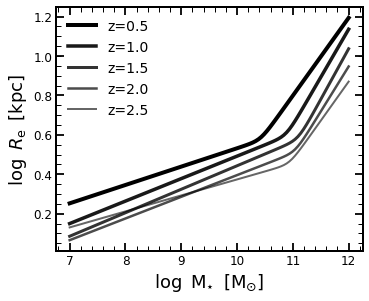

In [6]:
# plot size-mass relation

log_mass_plot = np.linspace(7.0, 12.0, num=100)


fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5.5, 4.5))

# plot observations
#ax.plot(log_mass_plot, get_size_observations(0.0, log_mass_plot, True), '-', lw=3, color='C0', label='SF: z=0')
#ax.plot(log_mass_plot, get_size_observations(0.25, log_mass_plot, True), '--', lw=3, color='C0', label='SF: z=0.25')
#ax.plot(log_mass_plot, get_size_observations(1.0, log_mass_plot, True), '--', lw=3, color='C0', label='SF: z=1')
#ax.plot(log_mass_plot, get_size_observations(2.0, log_mass_plot, True), ':', lw=3, color='C0', label='SF: z=2')
#ax.plot(log_mass_plot, get_size_observations(0.0, log_mass_plot, False), '-', lw=3, color='C3', label='Q: z=0')
#ax.plot(log_mass_plot, get_size_observations(0.25, log_mass_plot, False), '--', lw=3, color='C3', label='Q: z=0.25')
#ax.plot(log_mass_plot, get_size_observations(1.0, log_mass_plot, False), '--', lw=3, color='C3', label='Q: z=1')
#ax.plot(log_mass_plot, get_size_observations(2.0, log_mass_plot, False), ':', lw=3, color='C3', label='Q: z=2')

ax.plot(log_mass_plot, get_size_observations_all(0.5, log_mass_plot, 'r50'), '-', lw=4.0, alpha=1.0, color='black', label='z=0.5')
ax.plot(log_mass_plot, get_size_observations_all(1.0, log_mass_plot, 'r50'), '-', lw=3.5, alpha=0.9, color='black', label='z=1.0')
ax.plot(log_mass_plot, get_size_observations_all(1.5, log_mass_plot, 'r50'), '-', lw=3.0, alpha=0.8, color='black', label='z=1.5')
ax.plot(log_mass_plot, get_size_observations_all(2.0, log_mass_plot, 'r50'), '-', lw=2.5, alpha=0.7, color='black', label='z=2.0')
ax.plot(log_mass_plot, get_size_observations_all(2.5, log_mass_plot, 'r50'), '-', lw=2.0, alpha=0.6, color='black', label='z=2.5')



# set axes
ax.set_xlabel(r'$\log\/\/\/\mathrm{M_{\star}}\/\/\/[\mathrm{M_{\odot}}]$', fontsize=18)
ax.set_ylabel(r'$\log\/\/\/R_{\rm e}\/\/\/[\mathrm{kpc}]$', fontsize=18)

#ax.set_xlim([9.0, 11.5])
#ax.set_ylim([-0.3, 1.5])

ax.legend(frameon=False, fontsize=14, loc='upper left')

plt.show()


# Sample space

In [11]:
# define functions

def sigmoid(x, a, b, c):
    return(b/(1.0+np.exp(-a*(x-c))))

def exp_fct(x, a, b):
    f = 1.0+np.exp(a*(x-b))
    return(f)

def get_properties(redshift_in, alpha, beta, gamma, delta, epsilon):
    '''
    This function returns masses and sizes for a given redshift and parameters.
    '''
    redshift_list = []
    mass_list = []
    RM_list = []
    for SFH_file in list_SFH_tables:
        # read in table
        SFH_table = Table.read(SFH_file, format='ascii', names=('scale_factor', 'SFH_all', 'SFH_all_up', 'SFH_all_dw', 'SFH_SF', 'SFH_SF_up', 'SFH_SF_dw', 'SFH_Q', 'SFH_Q_up', 'SFH_Q_dw', 'SFH_Cen', 'SFH_Cen_up', 'SFH_Cen_dw', 'SFH_Sat', 'SFH_Sat_up', 'SFH_Sat_dw', 'scale_factor_begin', 'scale_factor_end')) 
        # set up galaxies and get props
        gal = toolbox_morph.galaxy(radius_kpc, SFH_table['scale_factor'], SFH_table['SFH_all'], [alpha, beta, gamma])
        for ii_z in redshift_in:
            RM = gal.get_size(redshift_in=ii_z)
            mass = gal.get_mass_after_mass_loss(redshift_in=ii_z)
            # merging
            # merger_eff = sigmoid(np.log10(mass), delta, epsilon, 11.2)
            merger_eff = exp_fct(np.log10(mass), delta, epsilon)
            mass = merger_eff*mass
            RM = merger_eff*RM
            # append
            redshift_list.append(ii_z)
            mass_list.append(mass)
            RM_list.append(RM)
    # convert lists to arrays
    redshift_list = np.array(redshift_list)
    mass_list = np.array(mass_list)
    RM_list = np.array(RM_list)
    return(redshift_list, mass_list, RM_list)


In [8]:
# define functions: for star-forming and quiescent galaxies

def get_properties_SFQ(redshift_in, alpha, beta, gamma, delta):
    '''
    This function returns masses and sizes for a given redshift and parameters.
    '''
    redshift_list = []
    mass_Q_list = []
    mass_SF_list = []
    RM_Q_list = []
    RM_SF_list = []
    #S1_Q_list = []
    #S1_SF_list = []
    for SFH_file in list_SFH_tables:
        # read in table
        SFH_table = Table.read(SFH_file, format='ascii', names=('scale_factor', 'SFH_all', 'SFH_all_up', 'SFH_all_dw', 'SFH_SF', 'SFH_SF_up', 'SFH_SF_dw', 'SFH_Q', 'SFH_Q_up', 'SFH_Q_dw', 'SFH_Cen', 'SFH_Cen_up', 'SFH_Cen_dw', 'SFH_Sat', 'SFH_Sat_up', 'SFH_Sat_dw', 'scale_factor_begin', 'scale_factor_end')) 
        # set up galaxies (SF and Q) and get props
        gal_Q = toolbox_morph.galaxy(radius_kpc, SFH_table['scale_factor'], SFH_table['SFH_Q'], [alpha, beta, gamma, delta])
        gal_SF = toolbox_morph.galaxy(radius_kpc, SFH_table['scale_factor'], SFH_table['SFH_SF'], [alpha, beta, gamma, delta])
        for ii_z in redshift_in:
            RM_Q = gal_Q.get_size(redshift_in=ii_z)
            RM_SF = gal_SF.get_size(redshift_in=ii_z)
            #S1_Q = gal_Q.get_mass_within_R(Rmax=1.0, redshift_in=redshift_in)/np.pi
            #S1_SF = gal_SF.get_mass_within_R(Rmax=1.0, redshift_in=redshift_in)/np.pi
            mass_Q = gal_Q.get_mass_after_mass_loss(redshift_in=ii_z)
            mass_SF = gal_SF.get_mass_after_mass_loss(redshift_in=ii_z)
            # append
            redshift_list.append(ii_z)
            mass_Q_list.append(mass_Q)
            mass_SF_list.append(mass_SF)
            RM_Q_list.append(RM_Q)
            RM_SF_list.append(RM_SF)
            #S1_Q_list.append(S1_Q)
            #S1_SF_list.append(S1_SF)
    # convert lists to arrays
    redshift_list = np.array(redshift_list)
    mass_Q_list = np.array(mass_Q_list)
    mass_SF_list = np.array(mass_SF_list)
    RM_Q_list = np.array(RM_Q_list)
    RM_SF_list = np.array(RM_SF_list)
    #S1_Q_list = np.array(S1_Q_list)
    #S1_SF_list = np.array(S1_SF_list)
    # sort
    #sort_index = redshift_list.argsort()
    return(redshift_list, mass_Q_list, mass_SF_list, RM_Q_list, RM_SF_list)


In [12]:
# testing

get_properties([0.5, 1.0, 2.0], 1, 1, 1, 1, 1)


(array([0.5, 1. , 2. , 0.5, 1. , 2. , 0.5, 1. , 2. , 0.5, 1. , 2. , 0.5,
        1. , 2. , 0.5, 1. , 2. , 0.5, 1. , 2. , 0.5, 1. , 2. , 0.5, 1. ,
        2. , 0.5, 1. , 2. , 0.5, 1. , 2. , 0.5, 1. , 2. , 0.5, 1. , 2. ,
        0.5, 1. , 2. ]),
 array([1.39743428e+12, 4.35025994e+11, 8.41345097e+10, 2.87635172e+12,
        8.21653692e+11, 1.48733407e+11, 6.18368993e+12, 1.62542722e+12,
        2.74795598e+11, 1.37766747e+13, 3.41188229e+12, 5.21152120e+11,
        3.19141040e+13, 8.01405353e+12, 1.10367218e+12, 7.36490749e+13,
        2.07057659e+13, 2.57402513e+12, 1.67769252e+14, 5.72042488e+13,
        6.87615482e+12, 3.63757857e+14, 1.56752661e+14, 1.93837699e+13,
        7.57451828e+14, 4.08966465e+14, 5.45394292e+13, 1.51906638e+15,
        9.93713291e+14, 1.66326303e+14, 2.96825301e+15, 2.26931827e+15,
        5.19353626e+14, 5.78107016e+15, 4.94892357e+15, 1.69457837e+15,
        1.10926222e+16, 1.01149501e+16, 4.80520956e+15, 2.12502775e+16,
        1.99377268e+16, 1.22352442e+

In [13]:
# define log-likelihood

def loglike(theta):
    a, b, c, d, e = theta
    redshift, mass, RM = get_properties(redshift_fit, a, b, c, d, e)
    data_minus_model = np.zeros(len(redshift))
    for ii_z in redshift_fit:
        R_obs = get_size_observations_all(ii_z, np.log10(mass[redshift == ii_z]), 'r50')
        data_minus_model[redshift == ii_z] = 10**R_obs-RM[redshift == ii_z]
    inv_sigma2 = 1.0
    log_like = -0.5 * (np.sum((data_minus_model)**2 * inv_sigma2 - np.log(inv_sigma2)))
    return(log_like)


In [14]:
# define log-likelihood

def loglike_SFQ(theta):
    a, b, c, d = theta
    redshift, mass_Q, mass_SF, RM_Q, RM_SF = get_properties(redshift_fit, a, b, c, d)
    data_minus_model_Q = np.zeros(len(redshift))
    data_minus_model_SF = np.zeros(len(redshift))
    for ii_z in redshift_fit:
        R_obs_Q = get_size_observations(ii_z, np.log10(mass_Q[redshift == ii_z]), False)
        R_obs_SF = get_size_observations(ii_z, np.log10(mass_SF[redshift == ii_z]), True)
        data_minus_model_Q[redshift == ii_z] = R_obs_Q-np.log10(RM_Q[redshift == ii_z])
        data_minus_model_SF[redshift == ii_z] = R_obs_SF-np.log10(RM_SF[redshift == ii_z])
    inv_sigma2 = 1.0
    log_like = -0.5 * (np.sum(((data_minus_model_Q)**2 +(data_minus_model_SF)**2) * inv_sigma2 - np.log(inv_sigma2)))
    return(log_like)


In [14]:
# define prior transform

# alpha: normalization
# beta: mass dependence => (M/10**10)**beta
# gamma: redshift dependence => (1+z)**delta
# delta: power in exponential in merger efficiency: np.exp(delta*(x-epsilon))
# epsilon: mass scale in exponential in merger efficiency: np.exp(delta*(x-epsilon))


def prior_transform(utheta):
    """Transforms our unit cube samples 'u' to those from a flat prior
    between in each variable."""
    u_a, u_b, u_c, u_d, u_e = utheta
    a = 50. * u_a
    b = 3. * (2. * u_b - 1.)
    c = 3. * (2. * u_c - 1.)
    d = 6. * u_d
    e = u_e + 10.5
    return a, b, c, d, e


# define redshift of fitting

redshift_fit = np.array([0.5, 1.0, 1.5, 2.0, 2.5])



In [15]:
# define the sampler, takes a couple of minutes

dsampler = dynesty.NestedSampler(loglike, prior_transform, ndim=5, nlive=100,
                                        bound='multi', sample='unif',
                                        first_update={'min_ncall': -np.inf, 'min_eff': np.inf},
                                        update_interval=0.5)


/Users/sandrotacchella/ASTRO/SRMP/morph_project/morph_tools/toolbox_morph.py:103: RuntimeWarning: divide by zero encountered in power
  self.Rs = self.Rs_params[0]*(self.mass/10**10)**self.Rs_params[1]*(1+self.redshift)**self.Rs_params[2]  # ((self.SFR/self.mass)/10**-10)**self.Rs_params[2]


In [27]:
# sample space, takes about 3 hours

dsampler.run_nested(dlogz=0.01)


iter: 2199+100 | bound: 114 | nc: 1 | ncall: 6127 | eff(%): 37.522 | loglstar:   -inf < -15.018 <    inf | logz: -32.284 +/-  0.384 | dlogz:  0.000 >  0.010            

# Plot results

In [28]:
# get results

dres = dsampler.results


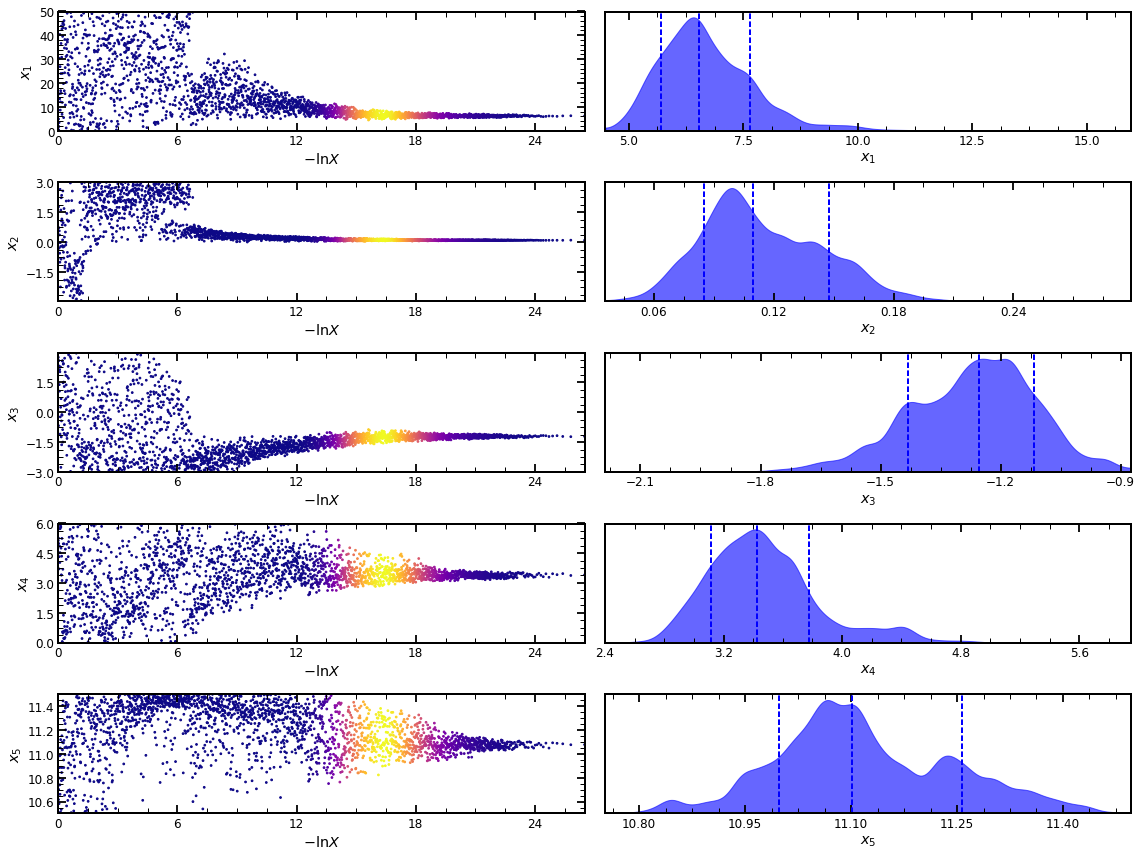

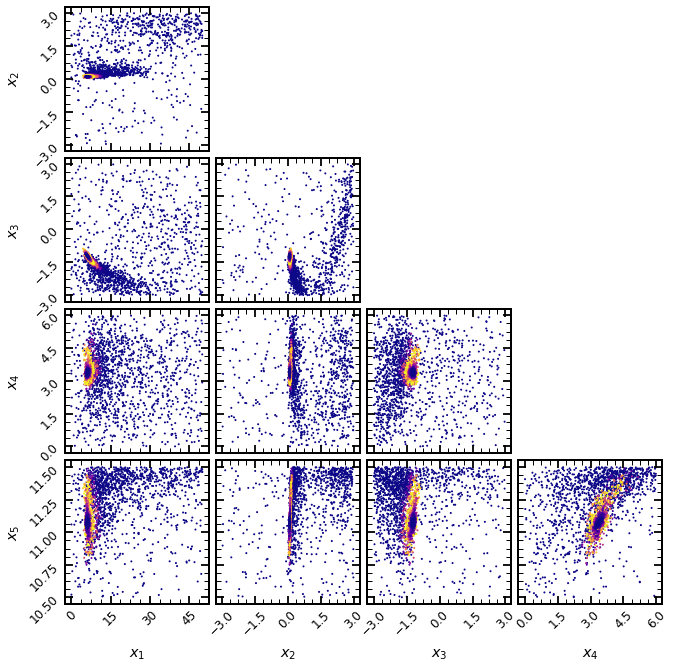

In [29]:
# plot results (i.e. posteriors):
# x1: normalization of SFR profile
# x2: mass-dependence of SFR profile
# x3: redshift-dependence of SFR profile
# x4: power in exponential of merger efficiency
# x5: critical mass scale of merger efficiency

# trace plot
fig, axes = dyplot.traceplot(dsampler.results, 
                             fig=plt.subplots(5, 2, figsize=(16, 12)))
fig.tight_layout()
plt.show()

# corner plot
fig, axes = dyplot.cornerpoints(dres)
plt.show()


In [30]:
# compute first moments of posteriors

samples, weights = dres.samples, np.exp(dres.logwt - dres.logz[-1])
mean, cov = dyfunc.mean_and_cov(samples, weights)

alpha_best, beta_best, gamma_best, delta_best, epsilon_best = mean
print(alpha_best, beta_best, gamma_best, delta_best, epsilon_best)


(6.68490802883281, 0.11450591168014501, -1.271814494040584, 3.4728964521267636, 11.117397577620254)


In [31]:
# compute masses and sizes for these galaxies at certain redshifts

redshift_plot = np.array([0.5, 1.0, 1.5, 2.0])

z, mass, RM = get_properties(redshift_plot, alpha_best, beta_best, gamma_best, delta_best, epsilon_best)


56


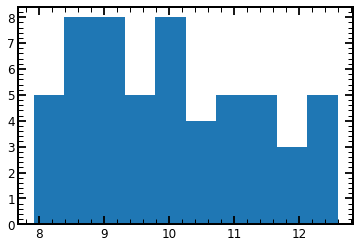

In [32]:
# mass distribution of galaxies (all redshift combined)

plt.hist(np.log10(mass))
print len(mass)
plt.show()

In [43]:
# prepare plot

log_mass_plot = np.linspace(9.0, 11.8)

def plot_model_and_obs(ax, ii_z):
    idx_s = mass[redshift==ii_z].argsort()
    ax.plot(np.log10(mass[redshift==ii_z][idx_s]), np.log10(RM[redshift==ii_z][idx_s]), '-', color='red', label='Model')
    # plot observations
    ax.plot(log_mass_plot, get_size_observations_all(ii_z, log_mass_plot, 'r50'), '-', lw=4, color='gray', label='Observations')
    # add redshift text
    ax.text(9.15, 1.15, 'z = ' + str(ii_z), fontsize=18)
    # set axes
    ax.set_xlabel(r'$\log\/\/\/\mathrm{M_{\star}}\/\/\/[\mathrm{M_{\odot}}]$', fontsize=18)
    ax.set_ylabel(r'$\log\/\/\/R_{\rm e}\/\/\/[\mathrm{kpc}]$', fontsize=18)
    ax.set_xlim([9.0, 11.5])
    ax.set_ylim([0.2, 1.3])


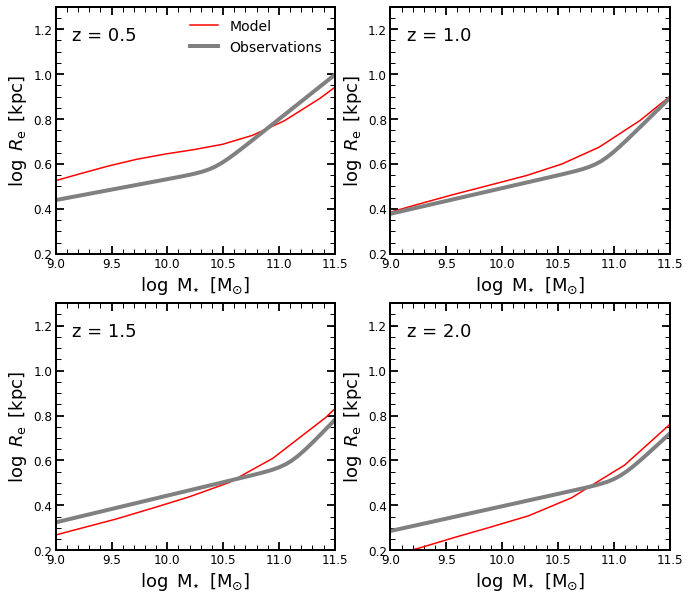

In [45]:
# compare model size-mass relation with observed size-mass relation

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(11, 10))

plot_model_and_obs(ax1, redshift_plot[0])
plot_model_and_obs(ax2, redshift_plot[1])
plot_model_and_obs(ax3, redshift_plot[2])
plot_model_and_obs(ax4, redshift_plot[3])

ax1.legend(frameon=False, fontsize=14, loc=1)

plt.show()


# Testing

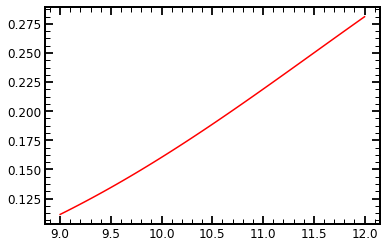

In [19]:
# test sigmoid function

def sigmoid(x, a, b, c):
    return(b/(1.0+np.exp(-a*(x-c))))

x = np.linspace(9.0, 12.0)

plt.plot(x, sigmoid(x, 0.5, 0.5, 11.5), '-', color='red')

plt.show()


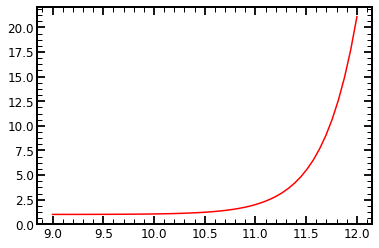

In [62]:
# text exponential function

def exp_fct(x, a, b):
    f = 1.0+np.exp(a*(x-b))
    return(f)

x = np.linspace(9.0, 12.0)

plt.plot(x, exp_fct(x, 3, 11.0), '-', color='red')

plt.show()
